# Clustering and dimensionality reduction (Unsupervised learning)
Let's carry out clustering in such a way that it well separates survivors from non-survivors. In principle, one could take any column, for example Pclass.

We will look at the quality of division into clusters using the Adjusted Rand Index metric. This metric evaluates the quality of the existing markup. In addition, we will try to evaluate the quality of clustering using the interia_ and Silhouette metrics, which do not require markings. Detailed descriptions of the metrics are given below.

# Short Abstract:
This analysis focuses on applying clustering and dimensionality reduction techniques, particularly KMeans clustering and Principal Component Analysis (PCA), to the Titanic dataset. The goal is to separate survivors from non-survivors effectively. Various metrics such as Adjusted Rand Index, Silhouette coefficient, and Inertia are utilized to evaluate the quality of clustering. The analysis also explores the impact of scaling and normalization on clustering performance.

## Statement of the Problem/Goal of the Analysis and Description of the Dataset(s):
The objective is to cluster Titanic passengers based on features such as ticket class, age, and fare to discern any patterns related to survival. The dataset contains information about passengers including their survival status (survived or not), ticket class, age, sex, and fare.

## List of Findings/Keypoints:
### Clustering Evaluation:
- Adjusted Rand Index (ARI) indicates that the clustering is close to random (ARI = 0.042).
- Silhouette coefficient suggests relatively well-defined clusters with a score of 0.791.
- Inertia analysis shows a decrease in inertia with an increasing number of clusters, suggesting potential for more than two clusters.
### Impact of Data Distribution:
- Clustering uniform distribution shows low inertia and silhouette scores, indicating the absence of a clear cluster structure.
- Clustering data with five clusters and a normal distribution around their centers results in a distinct decrease in inertia at five clusters, indicating a potential optimal number of clusters.
### Scaling and Normalization:
- Scaling the dataset reduces inertia, suggesting that the original data varied on a larger scale.
- Adjusted Rand Index remains relatively unchanged after scaling, indicating limited improvement in clustering quality.

## Theoretical Background of Used Methods:
- Adjusted Rand Index (ARI): Measures the similarity between two different clusterings, ranging from -1 (independent) to 1 (identical).
- Silhouette coefficient: Evaluates the quality of clustering based on the average distance between clusters and within clusters, ranging from -1 to 1.
- PCA: Reduces the dimensionality of data while preserving most of its variance, enabling visualization and analysis of high-dimensional datasets.
- KMeans Clustering: A partitioning algorithm that divides data into K distinct, non-overlapping clusters.

## Conclusions:
- Clustering analysis on the Titanic dataset using KMeans reveals potential for more than two clusters, supported by various evaluation metrics.
- Scaling and normalization improve clustering performance, albeit marginally.
- PCA aids in visualizing high-dimensional data but does not significantly enhance clustering quality in this context.
- Further exploration with alternative clustering algorithms such as DBSCAN may be beneficial, especially considering the dataset's complex cluster structure. Additionally, incorporating partial data labeling could enhance clustering accuracy.


In [28]:
library(dplyr)
library(tidyr)

In [52]:
df <- read.csv("Titanic train.csv", sep=',') 

In [53]:
head(df, 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S


In [54]:
dim(df)

[1] 891  12

In [55]:
summary(df)

  PassengerId       Survived          Pclass          Name          
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000   Length:891        
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median :446.0   Median :0.0000   Median :3.000   Mode  :character  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309                     
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :891.0   Max.   :1.0000   Max.   :3.000                     
                                                                    
     Sex                 Age            SibSp           Parch       
 Length:891         Min.   : 0.42   Min.   :0.000   Min.   :0.0000  
 Class :character   1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000  
 Mode  :character   Median :28.00   Median :0.000   Median :0.0000  
                    Mean   :29.70   Mean   :0.523   Mean   :0.3816  
                    3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:0.0000  
                    Max.   :80.00 

In [56]:
# Data Manipulation and Preprocessing:
df$Sex_float <- as.numeric(factor(df$Sex, levels = c('male', 'female')))

# Display counts of 'Embarked' including NA values
table(df$Embarked, useNA = "ifany")

# Fill NA values in 'Embarked' with 'S'
df$Embarked[is.na(df$Embarked)] <- 'S'

# Perform dummy encoding on 'Embarked'
df <- df %>%
  mutate(Embarked = factor(Embarked)) %>%
  tidyr::pivot_wider(names_from = Embarked, values_from = Embarked,
                     values_fill = list(Embarked = 0), values_fn = list(Embarked = length),
                     names_prefix = "Embarked_") %>%
  mutate_at(vars(starts_with("Embarked_")), ~ifelse(. > 0, 1, 0))


      C   Q   S 
  2 168  77 644 

In [57]:
df$Age <- ifelse(is.na(df$Age), median(df$Age, na.rm = TRUE), df$Age)

In [58]:
df_number_columns <- df[c('Pclass', 'Sex_float', 'Age', 'SibSp', 'Parch', 
                        'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S')]

In [59]:
df_number_columns

Pclass,Sex_float,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,22,1,0,7.2500,0,0,1
1,2,38,1,0,71.2833,1,0,0
3,2,26,0,0,7.9250,0,0,1
1,2,35,1,0,53.1000,0,0,1
3,1,35,0,0,8.0500,0,0,1
3,1,28,0,0,8.4583,0,1,0
1,1,54,0,0,51.8625,0,0,1
3,1,2,3,1,21.0750,0,0,1
3,2,27,0,2,11.1333,0,0,1


In [63]:
set.seed(0)
kmeans_result <- kmeans(df_number_columns, centers = 2)

In [61]:
kmeans_result <- kmeans(df_number_columns, centers = 2)
# Accessing cluster labels
cluster_labels <- kmeans_result$cluster

In [62]:
# Accessing cluster centers
cluster_centers <- kmeans_result$centers

## Let's measure the quality using the finished markup
### Adjusted Rand Index (ARI)

It is assumed that the true object labels are known. This measure does not depend on the label values themselves, but only on the division of the sample into clusters. Let $N$ be the number of objects in the sample. Let us denote by $a$ the number of pairs of objects that have the same labels and are in the same cluster, and by $b$ the number of pairs of objects that have different labels and are in different clusters. Then the Rand Index is $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$ That is, this is the proportion of objects for which these partitions (the original and those obtained as a result of clustering ) "agreed". The Rand Index (RI) expresses the similarity of two different clusterings of the same sample. In order for this index to give values close to zero for random clusterings for any $N$ and number of clusters, it is necessary to normalize it. This is how the Adjusted Rand Index is determined: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI} ]}.$$

This measure is symmetric and does not depend on the values and permutations of labels. Thus, this index is a measure of the distance between different sample splits. $\text{ARI}$ takes values in the range $[-1, 1]$. Negative values correspond to "independent" cluster splits, values close to zero indicate random splits, and positive values indicate that the two splits are similar (the same when $\text{ARI} = 1$).

https://en.wikipedia.org/wiki/Rand_index

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

In [65]:
# Load the mclust package
library(mclust)

# Calculate Adjusted Rand Index (ARI)
ari_value <- adjustedRandIndex(kmeans_result$cluster, df$Survived)

# Print the ARI value
print(ari_value)

Package 'mclust' version 6.1
Type 'citation("mclust")' for citing this R package in publications.



[1] 0.04287034


The metric is close to 0 – our clustering is close to random

## Let's measure the quality of clustering without taking into account labels
### Sum of squared distances to the nearest center:

In [67]:
total_within_ss <- kmeans_result$tot.withinss

In [68]:
total_within_ss

[1] 1000264

### Silhouette coefficient

This coefficient does not assume knowledge of the true object labels, and allows you to evaluate the quality of clustering using only the (unlabeled) sample itself and the clustering result. First, the silhouette is determined separately for each object. Let us denote by $a$ the average distance from a given object to objects from the same cluster, and by $b$ the average distance from a given object to objects from the nearest cluster (different from the one in which the object itself lies). Then the silhouette of this object is the quantity: $$s = \frac{b - a}{\max(a, b)}.$$
The silhouette of a sample is the average size of the silhouette of objects in a given sample. Thus, the silhouette shows how the average distance to objects in its own cluster differs from the average distance to objects of other clusters. This value lies in the range $[-1, 1]$. Values close to -1 correspond to poor (scattered) clusterings, values close to zero indicate that the clusters intersect and overlap each other, values close to 1 correspond to “dense” well-defined clusters. Thus, the larger the silhouette, the more clearly the clusters are identified, and they appear as compact, densely grouped point clouds.

Using the silhouette, you can select the optimal number of clusters $k$ (if it is unknown in advance) - the number of clusters that maximizes the value of the silhouette is selected. Unlike previous metrics, the silhouette depends on the shape of the clusters, and reaches higher values on more convex clusters obtained using algorithms based on density distribution reconstruction.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [69]:
# Load the cluster package
library(cluster)

# Compute the silhouette widths for each observation
sil_widths <- silhouette(kmeans_result$cluster, dist(df_number_columns))

# Calculate the average silhouette width
avg_sil_width <- mean(sil_widths[, "sil_width"])

# Print the average silhouette score
print(avg_sil_width)

[1] 0.7914459


By themselves, these metrics do not say anything, because... strongly depend on the dimension of space and the scale of features. But you can use them to select the number of clusters. Maybe there are more than 2 clusters in our data?

Let's go through a loop from 2 to 10 and build the interia and silhouette metrics

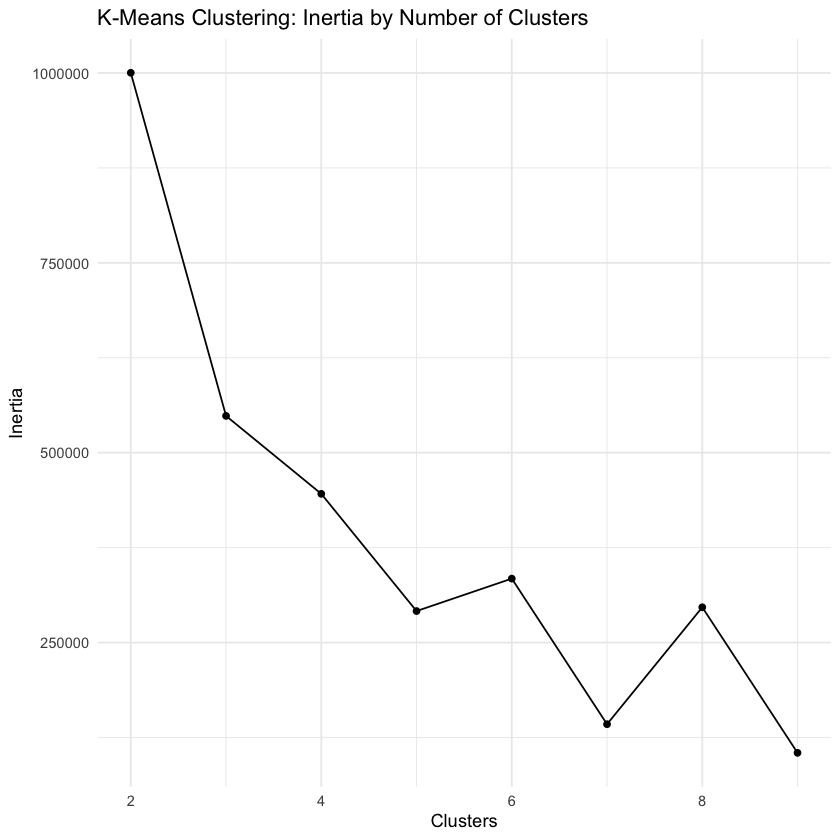

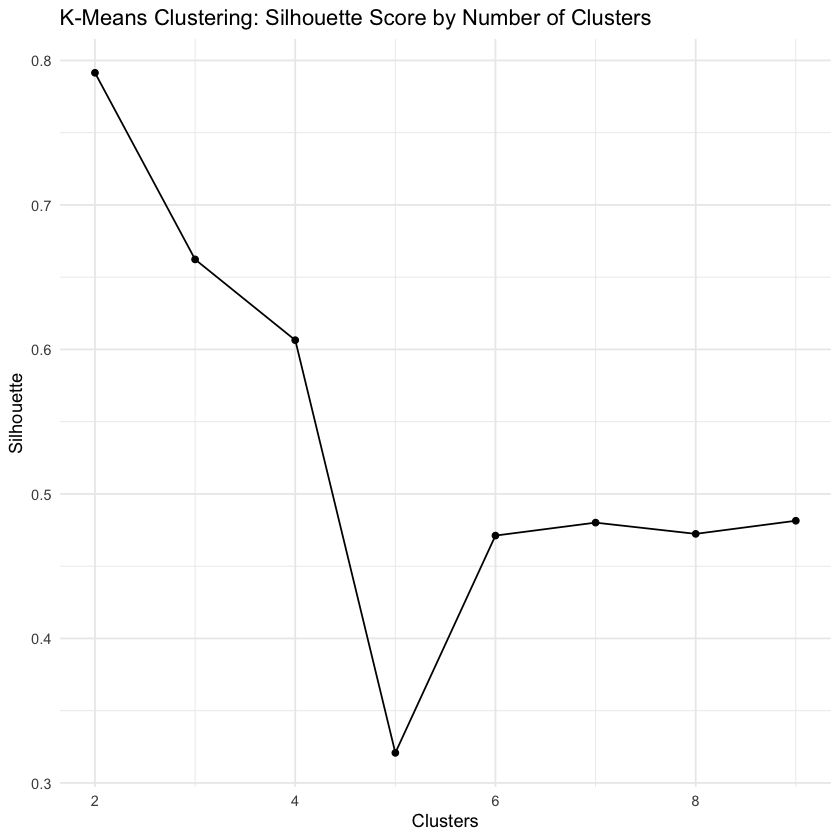

In [71]:
library(cluster) # For silhouette
library(ggplot2) # For plotting

# Initialize vectors to store results
inertias <- numeric()
silhouettes <- numeric()
cluster_range <- 2:9

# Loop through cluster numbers
for (i in cluster_range) {
  kmeans_result <- kmeans(df_number_columns, centers = i, nstart = 25) # Ensure reproducibility
  inertias[i - 1] <- kmeans_result$tot.withinss
  
  # Calculate silhouette score
  sil_widths <- silhouette(kmeans_result$cluster, dist(df_number_columns))
  silhouettes[i - 1] <- mean(sil_widths[, "sil_width"])
}

# Create a data frame for plotting
plot_data <- data.frame(Clusters = cluster_range, Inertia = inertias, Silhouette = silhouettes)

# Plotting Inertia
ggplot(plot_data, aes(x = Clusters, y = Inertia)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  ggtitle("K-Means Clustering: Inertia by Number of Clusters")

# Plotting Silhouette
ggplot(plot_data, aes(x = Clusters, y = Silhouette)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  ggtitle("K-Means Clustering: Silhouette Score by Number of Clusters")


The smaller the interia, the better our clustering. It is clear that the more clusters, the smaller the sum of squared distances to their centers. So it would be useful to compare our plot with the one obtained for data that is distributed evenly or, on the contrary, has a clear cluster structure

For silhouette the situation is not so clear-cut. Let's also see how this matrix behaves under different distributions in the data

Warning message:
“не сошлось за 10 итераций”
Warning message:
“не сошлось за 10 итераций”


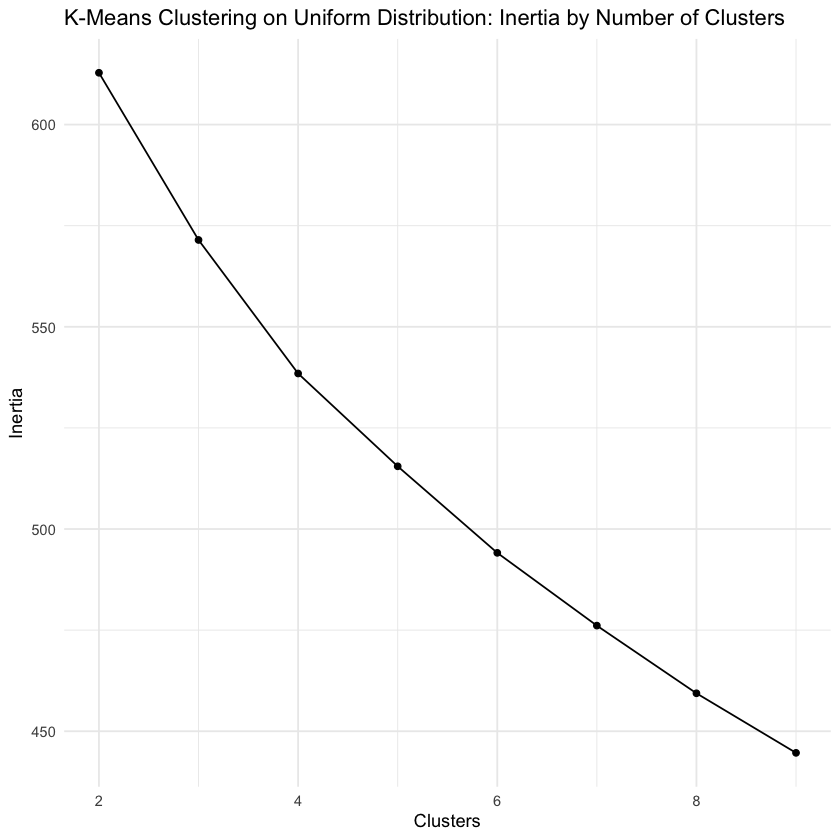

In [72]:
library(cluster) # For silhouette calculation
library(ggplot2) # For plotting

# Generate a uniform distribution matrix with the same shape as df_number_columns
uniform_distribution <- runif(n = nrow(df_number_columns) * ncol(df_number_columns))
dim(uniform_distribution) <- dim(df_number_columns)

# Initialize vectors to store results
inertias <- numeric()
silhouettes <- numeric()
cluster_range <- 2:9

# Loop through cluster numbers
for (i in cluster_range) {
  kmeans_result <- kmeans(uniform_distribution, centers = i, nstart = 25) # Ensure reproducibility with nstart
  inertias[i - 1] <- kmeans_result$tot.withinss
  
  # Calculate silhouette score
  sil_widths <- silhouette(kmeans_result$cluster, dist(uniform_distribution))
  silhouettes[i - 1] <- mean(sil_widths[, "sil_width"])
}

# Plotting Inertia
inertia_data <- data.frame(Clusters = cluster_range, Inertia = inertias)
ggplot(inertia_data, aes(x = Clusters, y = Inertia)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  ggtitle("K-Means Clustering on Uniform Distribution: Inertia by Number of Clusters")


For a normal distribution, interia falls linearly with respect to the number of clusters. This is not the case in the Titanic data - therefore, the data there is not entirely uniform

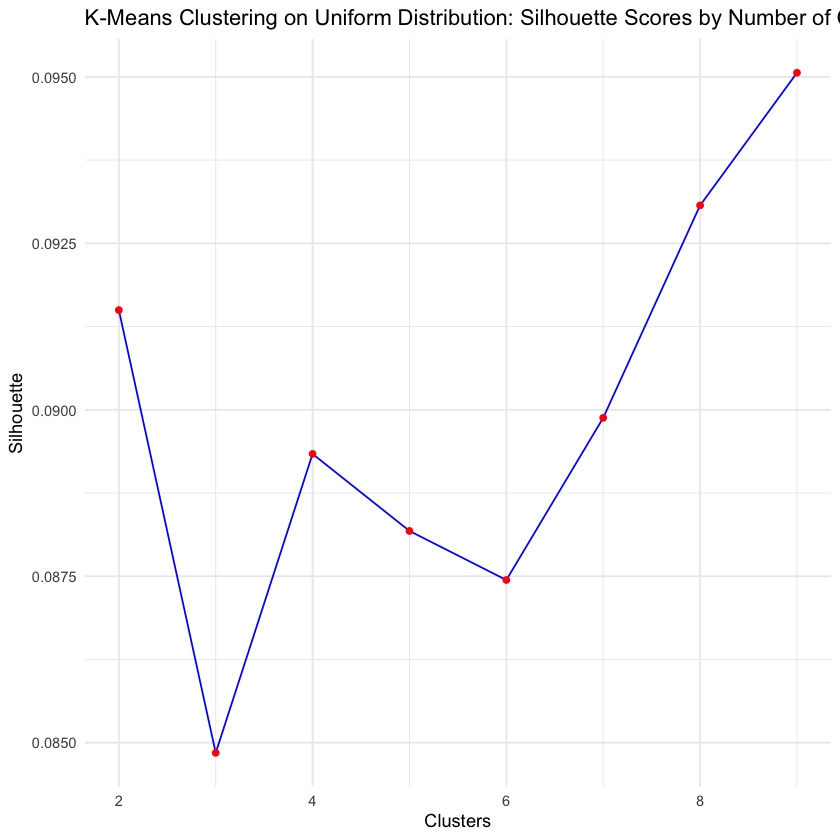

In [73]:
# Create a data frame for plotting silhouette scores
silhouette_data <- data.frame(Clusters = cluster_range, Silhouette = silhouettes)

# Plotting Silhouette Scores
ggplot(silhouette_data, aes(x = Clusters, y = Silhouette)) +
  geom_line(color = "blue") +  # Adding color for better visibility
  geom_point(color = "red") +  # Highlighting the data points
  theme_minimal() +
  ggtitle("K-Means Clustering on Uniform Distribution: Silhouette Scores by Number of Clusters")


We see that the silhouette metric is close to 0, which indicates the absence of a cluster structure in the data. The fluctuations in the graph are weak and a consequence of randomly generated data.

## Let's generate data with 5 clusters and a normal distribution around their centers.

In [78]:
# Assuming df_number_columns is your original data frame
n_samples <- nrow(df_number_columns)
n_features <- ncol(df_number_columns)
centers <- 5
cluster_std <- 4.0

# Generate cluster centers
center_coords <- matrix(rnorm(centers * n_features), ncol = n_features)

# Initialize matrix to store the generated data
normal_distribution <- matrix(nrow = n_samples, ncol = n_features)

# Assign each sample to a cluster and generate data
for (i in 1:n_samples) {
  cluster <- sample(1:centers, 1)  # Randomly assign to a cluster
  for (j in 1:n_features) {
    normal_distribution[i, j] <- rnorm(1, mean = center_coords[cluster, j], sd = cluster_std)
  }
}

Warning message:
“не сошлось за 10 итераций”
Warning message:
“не сошлось за 10 итераций”


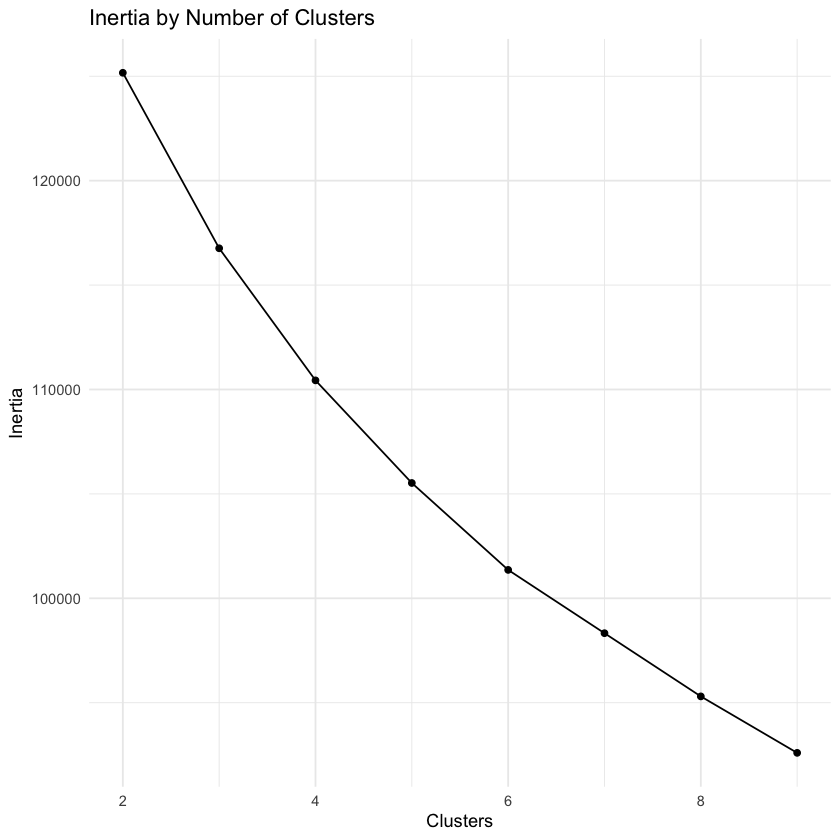

In [79]:
# Initialize vectors to store inertias and silhouette scores
inertias <- numeric(length = 8)
silhouettes <- numeric(length = 8)

# Loop through a range of cluster numbers from 2 to 9
for (i in 2:9) {
  set.seed(0)  # Ensure reproducibility
  kmeans_result <- kmeans(normal_distribution, centers = i, nstart = 25)
  
  # Store the total within-cluster sum of squares (inertia)
  inertias[i - 1] <- kmeans_result$tot.withinss
  
  # Calculate and store the silhouette score
  sil_widths <- silhouette(kmeans_result$cluster, dist(normal_distribution))
  silhouettes[i - 1] <- mean(sil_widths[, "sil_width"])
}

# Create a data frame for plotting
plot_data <- data.frame(Clusters = 2:9, Inertia = inertias)

# Plotting the inertias
ggplot(plot_data, aes(x = Clusters, y = Inertia)) +
  geom_line() + geom_point() +
  theme_minimal() +
  ggtitle("Inertia by Number of Clusters")

We see that inertia has a break at the number of clusters 5: kMeans managed to correctly split the data into clusters.

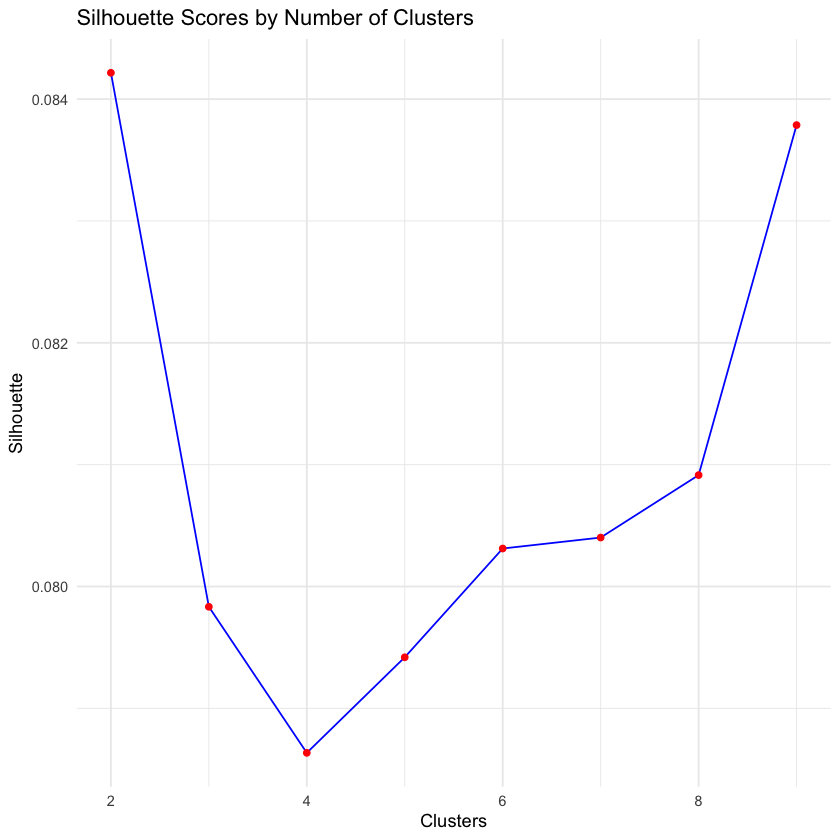

In [81]:
# Create a data frame for plotting silhouette scores
silhouette_data <- data.frame(Clusters = 2:9, Silhouette = silhouettes)

# Plotting Silhouette Scores
ggplot(silhouette_data, aes(x = Clusters, y = Silhouette)) +
  geom_line(color = "blue") +  # Line color
  geom_point(color = "red") +  # Point color
  theme_minimal() +
  ggtitle("Silhouette Scores by Number of Clusters")


silhouette also has quite high values at value 4. Then interia increase rapidly.

# Scale

At the very beginning, we made a mistake: we did not normalize the features. Indeed, if two features have different scales (and kmeans works with Eulerian space), then the feature with greater variance will be more significant for clustering. We can exploit this fact by assigning different degrees of importance to different features for clustering. But let’s now take the simple path and bring all the signs to the same scale: subtract its average value in each column and divide by the standard deviation. For this purpose, sklearn has the StandardScaler class

In [82]:
# Scale the dataset
df_number_columns_scaled <- scale(df_number_columns)

# Perform K-Means clustering with 2 clusters
set.seed(0)  # Ensure reproducibility
kmeans_result <- kmeans(df_number_columns_scaled, centers = 2, nstart = 25)

# Access the total within-cluster sum of squares (inertia)
inertia <- kmeans_result$tot.withinss

In [83]:
inertia

[1] 6308.373

We see that inertia has decreased. Apparently, our data varied on a larger scale than after scale. Unfortunately, after changing the data, any metrics that rely on distances (and all metrics that do not use labels have this property) cannot be compared with their previous values.

In [84]:
# Assuming df is your data frame and it has a 'Survived' column
# Assuming kmeans_result is the result from your KMeans clustering

# Load the mclust package
library(mclust)

# Calculate the Adjusted Rand Index
ari_value <- adjustedRandIndex(kmeans_result$cluster, df$Survived)

# Print the ARI value
print(ari_value)


[1] 0.0461144


adjusted_rand_score remained unchanged - scaling did not help. Let's re-run the experiments to determine a "good" value for the number of clusters in the data.

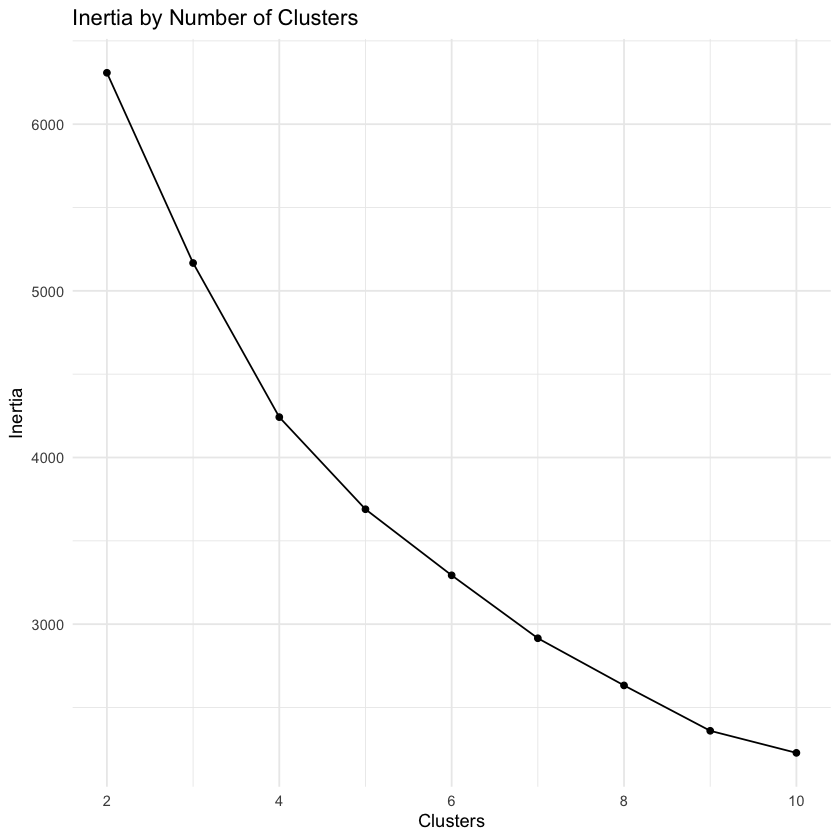

In [85]:
library(cluster)  # For silhouette scores
library(ggplot2)  # For plotting

# Assuming df_number_columns_scaled is your scaled dataset
inertias <- numeric(9)
silhouettes <- numeric(9)

for (i in 2:10) {
  set.seed(0)  # Ensure reproducibility
  kmeans_result <- kmeans(df_number_columns_scaled, centers = i, nstart = 25)
  inertias[i - 1] <- kmeans_result$tot.withinss
  
  silhouette_scores <- silhouette(kmeans_result$cluster, dist(df_number_columns_scaled))
  silhouettes[i - 1] <- mean(silhouette_scores[, "sil_width"])
}

# Create data frame for plotting
plot_data <- data.frame(Clusters = 2:10, Inertia = inertias)

# Plotting inertias
ggplot(plot_data, aes(x = Clusters, y = Inertia)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  ggtitle("Inertia by Number of Clusters")

# To plot silhouettes, replace Inertia with Silhouette in the ggplot call


The inertia graph now looks even more like the uniform distribution case. But it only takes into account distances within clusters, ignoring inter-cluster distances

## Dimensionality reduction

Due to the fact that kmeans operates in Euler space, it is subject to the so-called "curse of dimensionality". This is the effect when, as the dimension of space increases, the points become equally far from each other.
![](http://nikhilbuduma.com/img/dimension_sparsity.png)

The effect in different data appears at different values of dimension. In texts I noticed it at values >1000. Which is far from our situation with multiple columns. But let's practice

### PCA
Before applying PCA, it is important to scale and normalize the data accordingly. we will use df_number_columns_scaled

In [90]:
dim(df_number_columns_scaled)

[1] 891   9

In [91]:
# Perform PCA on the scaled data
pca_result <- prcomp(df_number_columns_scaled, center = FALSE, scale. = FALSE, rank. = 2)

# Explained variance ratio of the principal components
explained_variance_ratio <- pca_result$sdev^2 / sum(pca_result$sdev^2)

# Print the explained variance ratio for the first two components
print(explained_variance_ratio[1:2])


[1] 0.2400905 0.1962685


The explained_variance_ratio_ value shows how much information from the original dataset is contained in each of the new components.

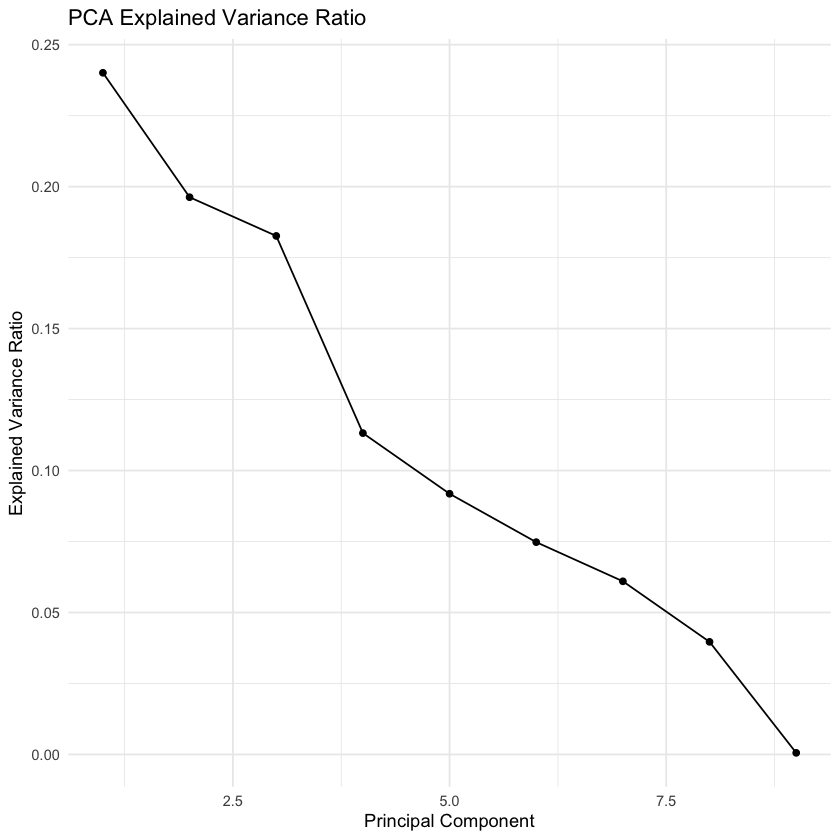

In [92]:
# Perform PCA
pca_result <- prcomp(df_number_columns_scaled, center = FALSE, scale. = FALSE)

# Calculate explained variance ratio
explained_variance_ratio <- pca_result$sdev^2 / sum(pca_result$sdev^2)

# Create a data frame for plotting
variance_df <- data.frame(Component = 1:length(explained_variance_ratio), Variance = explained_variance_ratio)

# Load ggplot2 for plotting
library(ggplot2)

# Plotting the explained variance ratio
ggplot(variance_df, aes(x = Component, y = Variance)) +
  geom_line() + geom_point() +
  theme_minimal() +
  xlab("Principal Component") + ylab("Explained Variance Ratio") +
  ggtitle("PCA Explained Variance Ratio")


We see that the columns after pca are sorted in reverse order by the amount of “saved” information.

Let's build a cumulative graph:

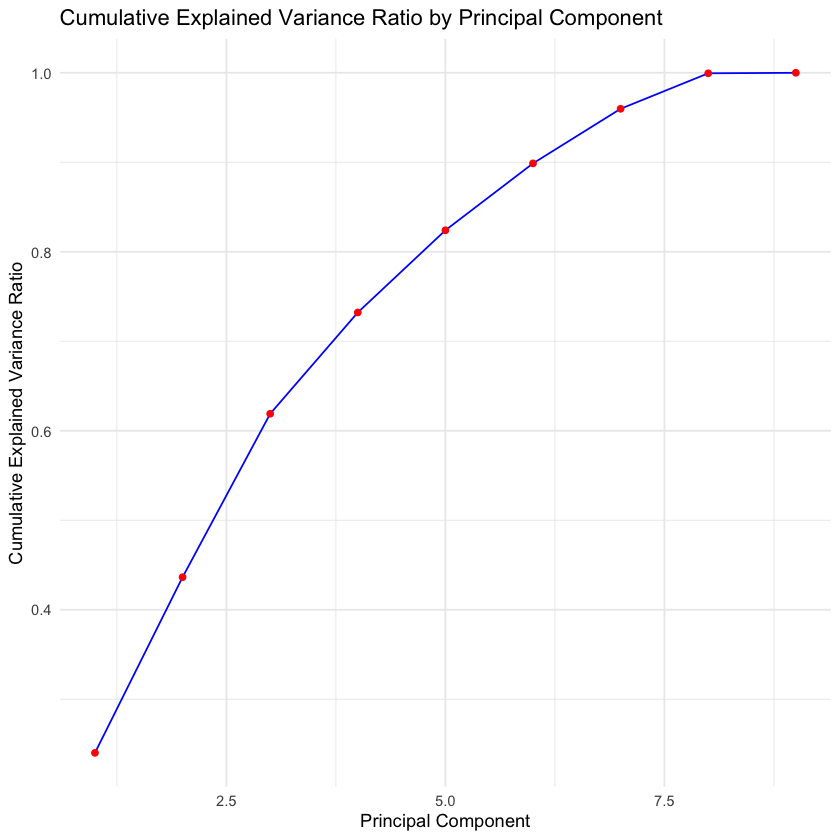

In [94]:
# Calculate cumulative explained variance ratio
cumulative_variance <- cumsum(pca_result$sdev^2 / sum(pca_result$sdev^2))

# Create a data frame for plotting
cumulative_variance_df <- data.frame(Component = 1:length(cumulative_variance), CumulativeVariance = cumulative_variance)

# Load ggplot2 for plotting
library(ggplot2)

# Plotting the cumulative explained variance ratio
ggplot(cumulative_variance_df, aes(x = Component, y = CumulativeVariance)) +
  geom_line(color = "blue") + geom_point(color = "red") +
  theme_minimal() +
  xlab("Principal Component") + ylab("Cumulative Explained Variance Ratio") +
  ggtitle("Cumulative Explained Variance Ratio by Principal Component")


You will notice that the 9th column (numbered 8) does not add any information. Apparently, there was a linear relationship in our data, which we can avoid using PCA.

Another useful use of dimensionality reduction is that if the dimension is 2D or 3D, we can look at our data.

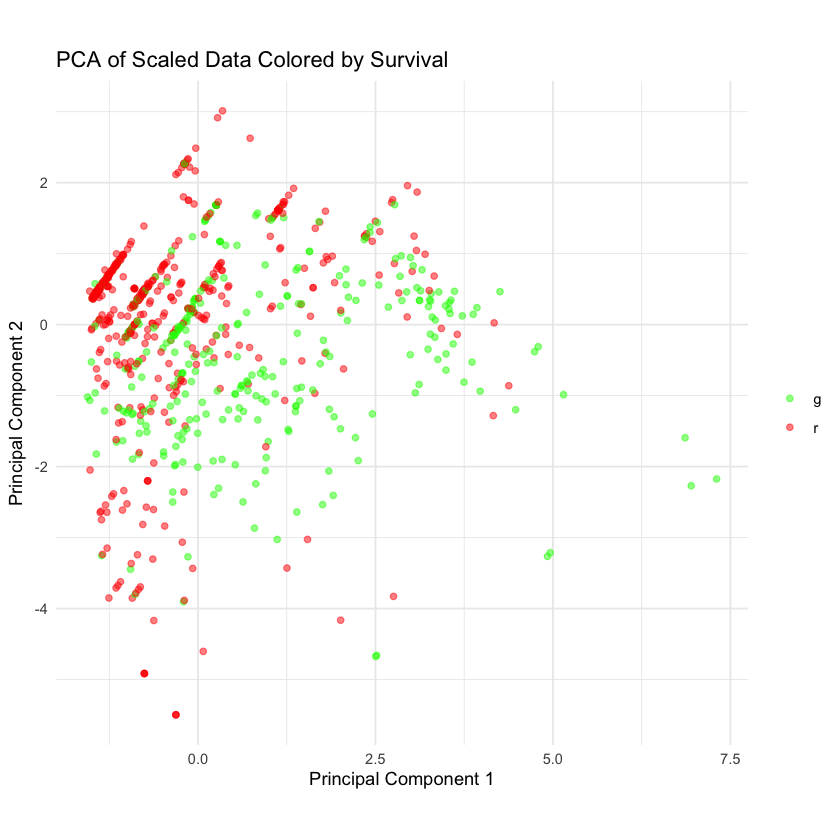

In [95]:
# Perform PCA on the scaled data
pca_result <- prcomp(df_number_columns_scaled, center = FALSE, scale. = FALSE, rank. = 2)

# Extract the first two principal components
df_number_columns_scaled_pca <- as.data.frame(pca_result$x[, 1:2])

# Assuming 'df' is your original data frame and it includes a 'Survived' column
# Add a 'Survived_color' column to the PCA data frame for plotting
df_number_columns_scaled_pca$Survived_color <- ifelse(df$Survived == 1, "g", "r")

# Load ggplot2 for plotting
library(ggplot2)

# Plotting the first two PCA components with colors
ggplot(df_number_columns_scaled_pca, aes(x = PC1, y = PC2, color = Survived_color)) +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c("g" = "green", "r" = "red")) +
  theme_minimal() +
  labs(title = "PCA of Scaled Data Colored by Survival", x = "Principal Component 1", y = "Principal Component 2") +
  theme(legend.title = element_blank()) + 
  coord_fixed()  # This sets an equal aspect ratio


What we can see in this graph:

- Green and red dots are distributed in different areas of the graph. Probably, supervised algorithms could cope with the classification.
- If you remove the color, no clustering algorithm will separate the red and green points into 2 clusters.

Let's run KMeans on the new data and see if the adjusted_rand_score metric has changed:

In [102]:
library(mclust)  # For calculating ARI

# Calculate the Adjusted Rand Index (ARI)
ari <- adjustedRandIndex(kmeans_result$cluster, df$Survived)

# Print the ARI
print(ari)


[1] 0.1280429


The metrics have not improved significantly. kMeans fraction of the 2-class case tries to draw a line between clusters of points. Those. will divide the space into 2 parts with a line. Our clusters have a more cunning structure. For such a case of such data, the DBSCAN algorithm is well suited.

In addition, visually there are 4 clusters, not 2. So we can’t do without partial data marking (to determine whether our cluster is “green” or “red”)